=====DATSCIW261 ASSIGNMENT #7=====


MIDS UC Berkeley, Machine Learning at Scale

DATSCIW261 ASSIGNMENT #7

#### Hetal Chandaria (hetalchandaria@berkeley.edu) 

W261 - 2 , ASSIGNMENT #7

Submission Date : 

Group : 4

===General Description===

In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

==================================== Undirected toy network dataset ================================

In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt

On under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

================================

==Directed toy network dataset==

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt

On under the Data Subfolder for HW7 on Dropbox with the same file name

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

==========================================================

### HW 7.0: Shortest path graph distances (toy networks)===

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

In [84]:
%%writefile mrjob_sssp_init.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
from ast import literal_eval
import sys

class Graph_init(MRJob):
    def steps(self):
        return [
            MRStep(mapper=self.mapper)
               ]
    
    def configure_options(self):
        super(Graph_init, self).configure_options()
        self.add_passthrough_option(
            '--Frontier',dest='frontier', type='str', default="1",
            help='Frontier: Starting node for the graph')
        
    def mapper(self,_,line):
        line = line.replace("\"","")
        t = line.strip().split('\t')
        node = t[0]
        if node == self.options.frontier:
            yield node,('{0}|{1}|{2}|{3}'.format(literal_eval(t[1]),0,self.options.frontier,'Q'))
        else:
            yield node,('{0}|{1}|{2}|{3}'.format(literal_eval(t[1]),sys.maxint,self.options.frontier,'U')) 
        
if __name__ == '__main__':
    Graph_init.run()    

Overwriting mrjob_sssp_init.py


In [85]:
!python mrjob_sssp_init.py --Frontier 1 -q test_directed2.txt > test-foo.txt

In [1]:
%%writefile mrjob_sssp.py

#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
from ast import literal_eval
import numpy as np
import sys

class SSSP(MRJob):
    visited_nodes = []
    num_visited = 0
    def steps(self):
        return [
            MRStep(mapper=self.mapper,reducer=self.reducer,jobconf={"mapred.map.tasks":8,
                            "mapred.reduce.tasks":8})
            
               ]
    
    def mapper(self,_,line):
        line = line.replace("\"","")
        t = line.strip().split('\t')
        node = t[0]
        neighbors_str,distance,path,state = t[1].split('|')
        if(neighbors_str != 'NULL'):
            neighbors = literal_eval(neighbors_str)
        else:
            neighbors='NULL'
        if state == 'Q':
            yield node,('{0}|{1}|{2}|{3}'.format(neighbors,distance,path,'V'))
            self.visited_nodes.append(node)
            if(neighbors != 'NULL'):
                for neighbor,weight in neighbors.iteritems():
#                     if neighbor in self.visited_nodes:
#                         continue
                    yield neighbor, ('{0}|{1}|{2}|{3}'.format('NULL',int(distance)+weight,str(path)+'->'+neighbor,'Q'))
        else:
            yield node,('{0}|{1}|{2}|{3}'.format(neighbors,distance,path,state))
        
    def reducer(self,key,value):
        node = key
        count = 0
        valList = [val for val in value]
        min_dist = sys.maxint
        if len(valList) ==1:
#             output = '{}\t{}'.format(node,valList[0])
            yield node, valList[0]
        else:
            neighbors = None
            dist = None
            path = None
            state = None
            
            for value in valList:
                t = value.split("|")
                if (int(t[1]) < min_dist):
                    distance = t[1]
                    path = t[2]
                    if (state == 'V'):
                        state = 'Q'
                    else:
                        state = t[3]
                    min_dist = int(t[1])
                if (t[3] == 'V' or t[3] == 'U'):
                    if (t[0] != 'NULL'):
                        neighbors = literal_eval(t[0])
                    else: neighbors = 'NULL'
                else: neighbors=t[0]
#             output = '{0}\t{1}|{2}|{3}|{4}'.format(node,neighbors,distance,path,state)    
            yield node, ('{0}|{1}|{2}|{3}'.format(neighbors,distance,path,state))
            

#         with open('/Users/hetal/programming/W261/UCB_MIDS_W261/hw7/Test.out','a') as f:
#             f.write(output)
#         f.close()
        
if __name__ == '__main__':
    SSSP.run()  

Overwriting mrjob_sssp.py


In [2]:
#!python mrjob_sssp.py test-foo.txt

In [88]:
%%writefile run_sssp.py

from mrjob_sssp_init import Graph_init
from mrjob_sssp import SSSP
import sys

#get file name  and starting node
if len(sys.argv) >1: start = int(sys.argv[2])
infile = sys.argv[1]

print start

mr_job = Graph_init(args=[infile , '--Frontier',str(start),
                    '--no-strict-protocol'])

with mr_job.make_runner() as runner: 
    runner.run()
    with open(infile+'out','w') as f:
        for line in runner.stream_output():
            output =  mr_job.parse_output_line(line)
            f.write(line)

iter_num = 0
last_num_visited = -1
while(True):
    any_in_queue = 0
    total_nodes = 0
    total_visited = 0
    print "Iteration:",iter_num
    mr_job = SSSP(args=[infile+'out','--no-strict-protocol'])
    with mr_job.make_runner() as runner: 
        runner.run()
        with open(infile+'out','w') as f:
            for line in runner.stream_output():
                f.write(line)
                total_nodes += 1
                node,value =  mr_job.parse_output_line(line)
                if value.endswith('V'):
                    total_visited += 1
                if value.endswith('Q'):
                    any_in_queue += 1
                print node,value
        f.close()
        iter_num +=1
        print "Total Nodes:",total_nodes
        print "Number of Visited Nodes:",total_visited
        if (any_in_queue > 0):
            print "Continue iteration as queued nodes left to visit"
            continue;
        if (total_nodes == total_visited ):
            print "Breaking out of loop as visited all nodes"        
            break;
        if (last_num_visited == total_visited ):
            print "Breaking out of loop as num visited is unchanged across iterations"        
            break;
        last_num_visited = total_visited
        if(iter_num==20): break
    


Overwriting run_sssp.py


In [77]:
!python run_sssp.py undirected_toy.txt 1

1
Iteration: 0
1 {'2': 1, '5': 1}|0|1|V
2 {'1': 1, '3': 1, '5': 1, '4': 1}|1|1->2|Q
3 {'2': 1, '4': 1}|9223372036854775807|1|U
4 {'3': 1, '2': 1, '5': 1}|9223372036854775807|1|U
5 {'1': 1, '2': 1, '4': 1}|1|1->5|Q
Total Nodes: 5
Number of Visited Nodes: 1
Continue iteration as queued nodes left to visit
Iteration: 1
1 {'2': 1, '5': 1}|0|1|V
2 {'1': 1, '3': 1, '5': 1, '4': 1}|1|1->2|V
3 {'2': 1, '4': 1}|2|1->2->3|Q
4 {'3': 1, '2': 1, '5': 1}|2|1->2->4|Q
5 {'1': 1, '2': 1, '4': 1}|1|1->5|V
Total Nodes: 5
Number of Visited Nodes: 3
Continue iteration as queued nodes left to visit
Iteration: 2
1 {'2': 1, '5': 1}|0|1|V
2 {'1': 1, '3': 1, '5': 1, '4': 1}|1|1->2|V
3 {'2': 1, '4': 1}|2|1->2->3|V
4 {'3': 1, '2': 1, '5': 1}|2|1->2->4|V
5 {'1': 1, '2': 1, '4': 1}|1|1->5|V
Total Nodes: 5
Number of Visited Nodes: 5
Breaking out of loop as visited all nodes


In [78]:
!python run_sssp.py directed_toy.txt 1

1
Iteration: 0
1 {'2': 1, '6': 1}|0|1|V
2 {'1': 1, '3': 1, '4': 1}|1|1->2|Q
3 {'2': 1, '4': 1}|9223372036854775807|1|U
4 {'2': 1, '5': 1}|9223372036854775807|1|U
5 {'1': 1, '2': 1, '4': 1}|9223372036854775807|1|U
6 NULL|1|1->6|Q
Total Nodes: 6
Number of Visited Nodes: 1
Continue iteration as queued nodes left to visit
Iteration: 1
1 {'2': 1, '6': 1}|0|1|V
2 {'1': 1, '3': 1, '4': 1}|1|1->2|V
3 {'2': 1, '4': 1}|2|1->2->3|Q
4 {'2': 1, '5': 1}|2|1->2->4|Q
5 {'1': 1, '2': 1, '4': 1}|9223372036854775807|1|U
6 NULL|1|1->6|V
Total Nodes: 6
Number of Visited Nodes: 3
Continue iteration as queued nodes left to visit
Iteration: 2
1 {'2': 1, '6': 1}|0|1|V
2 {'1': 1, '3': 1, '4': 1}|1|1->2|V
3 {'2': 1, '4': 1}|2|1->2->3|V
4 {'2': 1, '5': 1}|2|1->2->4|V
5 {'1': 1, '2': 1, '4': 1}|3|1->2->4->5|Q
6 NULL|1|1->6|V
Total Nodes: 6
Number of Visited Nodes: 5
Continue iteration as queued nodes left to visit
Iteration: 3
1 {'2': 1, '6': 1}|0|1|V
2 {'1': 1, '3': 1, '4': 1}|1|1->2|V
3 {'2': 1, '4': 1}|2|1->2->

In [137]:
! cat test_directed.txt

1	{'2': 1, '6': 1}
2	{'3': 1, '7': 1}
3	{'4': 1, '5': 1, '11': 10}
4	{'10': 5}
5	{'8': 1}
6	{'5': 1, '7': 1}
7	{'9': 1}
8	{'10': 1}
9	{}
10	{'9':1, '11': 1}
11	{}


In [79]:
!python run_sssp.py test_directed.txt 2

2
Iteration: 0
1 {'2': 1, '6': 1}|9223372036854775807|2|U
10 {'9': 1, '11': 1}|9223372036854775807|2|U
11 {}|9223372036854775807|2|U
2 {'3': 1, '7': 1}|0|2|V
3 {'11': 10, '5': 1, '4': 1}|1|2->3|Q
4 {'10': 5}|9223372036854775807|2|U
5 {'8': 1}|9223372036854775807|2|U
6 {'5': 1, '7': 1}|9223372036854775807|2|U
7 {'9': 1}|1|2->7|Q
8 {'10': 1}|9223372036854775807|2|U
9 {}|9223372036854775807|2|U
Total Nodes: 11
Number of Visited Nodes: 1
Continue iteration as queued nodes left to visit
Iteration: 1
1 {'2': 1, '6': 1}|9223372036854775807|2|U
10 {'9': 1, '11': 1}|9223372036854775807|2|U
11 {}|11|2->3->11|Q
2 {'3': 1, '7': 1}|0|2|V
3 {'11': 10, '5': 1, '4': 1}|1|2->3|V
4 {'10': 5}|2|2->3->4|Q
5 {'8': 1}|2|2->3->5|Q
6 {'5': 1, '7': 1}|9223372036854775807|2|U
7 {'9': 1}|1|2->7|V
8 {'10': 1}|9223372036854775807|2|U
9 {}|2|2->7->9|Q
Total Nodes: 11
Number of Visited Nodes: 3
Continue iteration as queued nodes left to visit
Iteration: 2
1 {'2': 1, '6': 1}|9223372036854775807|2|U
10 {'9': 1, '11': 

### ==Main dataset 1: NLTK synonyms==

In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. These data may be found at the location:

s3://ucb-mids-mls-networks/synNet/synNet.txt

s3://ucb-mids-mls-networks/synNet/indices.txt

On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

### HW 7.1: Exploratory data analysis (NLTK synonyms)===

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 

number links,

or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [ ]:
print " Graph Adjacency List"
!head -5 ./synNet/synNet.txt

print"\n Index list"
!head -5 ./synNet/indices.txt

In [142]:
%%writefile mrjob_synNet_eda.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
from ast import literal_eval
import numpy as np
import sys

class EDA(MRJob):
    visited_nodes = []
    num_visited = 0
    def steps(self):
        return [
            MRStep(mapper=self.mapper,combiner=self.combiner,reducer=self.reducer,
                   jobconf={
                            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapreduce.partition.keycomparator.options': '-k1,1n',
                            }
                  )
               ]
    
    def mapper(self,_,line):
        line = line.replace("\"","")
        t = line.strip().split('\t')
        node = t[0]
        neighbors = literal_eval(t[1])
        num_links = len(neighbors)
        self.increment_counter('graph', 'links', num_links)
        yield(num_links,1)
        for neighbor in neighbors:
            yield 'Nodes',neighbor
        
    
    def combiner(self,key,value):
        if key != 'Nodes' :
            yield key,sum(value)
        else :
            for val in value:
                yield key, val
        
        
    def reducer(self,key,value):
        if key != 'Nodes':
            yield key,sum(value)
        else :
            self.increment_counter('graph', 'nodes', len(set(value)))
        
if __name__ == '__main__':
    EDA.run()  

Overwriting mrjob_synNet_eda.py


In [144]:
! python mrjob_synNet_eda.py  -r hadoop -q ./synNet/synNet.txt >eda.out

### EDA results 


<img src="./img/synNet_eda.jpg"></img>

In [145]:
%matplotlib inline

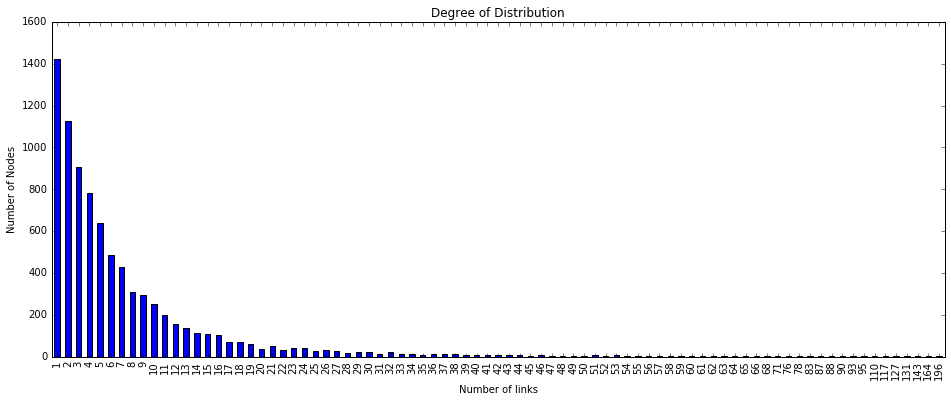

In [146]:
#plot degree of distribution
import pandas as pd
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
df = pd.read_csv('eda.out',sep='\t',header=None)
df.columns = ['links','nodes']
df.set_index('links',inplace=True)
df.plot(kind='bar',legend=None,title="Degree of Distribution",ax=ax)
plt.xlabel("Number of links")
plt.ylabel("Number of Nodes")


### HW 7.2: Shortest path graph distances (NLTK synonyms)===

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [130]:
%%writefile run_sssp_72.py

from mrjob_sssp_init import Graph_init
from mrjob_sssp import SSSP
import sys
import subprocess


def read_indices(idx_file):
    tmp_dict={}
    with open(idx_file,'r') as f:
        for line in f:
            t = line.strip().split('\t')
            tmp_dict[t[1]]=t[0]
    return tmp_dict

#get file name  and starting node
if len(sys.argv) == 6: 
    start = sys.argv[2]
    end = sys.argv[3]
    program = sys.argv[1]
    mode = sys.argv[4]
    cluster_id = sys.argv[5]
else:
    print "Invalid arguments."
    sys.exit(-1)

print start,end ,mode 

if(program =='wikipedia'):
    s3_source = 's3://hvcemrbucket/input/hw7/all-pages-indexed-out.txt'
    s3_path = 's3://hvcemrbucket/input/inter_input/wiki'
    index = './wikipedia/indices.txt'
    infile = './wikipedia/all-pages-indexed-out.txt'
    
else:
    s3_source = 's3://hvcemrbucket/input/hw7/synNet.txt'
    s3_path = 's3://hvcemrbucket/input/inter_input/synNet'
    index = './synNet/indices.txt'
    infile ='./synNet/synNet.txt'

if(mode =='hadoop'):
#     mrjobArgs += [
#         "hdfs://localhost:9000/user/hetal/hw7/" + infile,]
    mr_job = Graph_init(args=["hdfs://localhost:9000/user/hetal/hw7/" + infile , '--Frontier',str(start),'-r','hadoop',
                    '--no-strict-protocol'])

if mode=='emr':
#     cmd = 'aws s3 rm s3://hvcemrbucket/input/hw7/synNet --recursive'
#     subprocess.call(cmd, shell=True)
    outpath = 's3://hvcemrbucket/input/hw7/synNet/'
    mr_job = Graph_init(args=[s3_source,
                              '--Frontier',str(start),
                              '-r','emr',
                              '--emr-job-flow-id', cluster_id,
                              '--no-strict-protocol',
                              '--output-dir',s3_path+'/'
                             ])
else:
    mr_job = Graph_init(args=[infile , '--Frontier',str(start),
                    '--no-strict-protocol'])

    
with mr_job.make_runner() as runner: 
    runner.run()
    if(mode == 'local'):
        with open(infile+'out','w') as f:
            for line in runner.stream_output():
                output =  mr_job.parse_output_line(line)
                f.write(line)

if(mode=='hadoop'):
    cmd = "hdfs dfs -rm hw7/"+infile+"out"
    subprocess.call(cmd, shell=True)
    cmd = "hdfs dfs -copyFromLocal ./"+infile+"out hw7/"
    subprocess.call(cmd, shell=True)

# if(mode=='emr'):
#     inpath = "s3://hvcemrbucket/input/hw7/synNet"
   
            
iter_num = 0
last_num_visited = -1
path_to_end = None
path_found = False
while(True):
    any_in_queue = 0
    total_nodes = 0
    total_visited = 0
    print "Iteration:",iter_num
    if(mode =='hadoop'):
        mr_job = SSSP(args=["hdfs://localhost:9000/user/hetal/hw7/" + infile+'out' , '-r','hadoop','--no-strict-protocol'])
    
    elif mode=='emr':
        
        if iter_num == 0:  #first iteration we want to use the original source
            s3_source = s3_path + "/"
        else:  #after first iteration, we want to use the files created from previous iteration
            s3_source = s3_path + "_" + str(iter_num-1) + "/"

        #this will be the new location for files created
        s3_target = s3_path + "_"  + str(iter_num) + "/"

        mr_job = SSSP(args=[s3_source, 
                            '-r','emr',
                            '--no-strict-protocol',
                            '--emr-job-flow-id', cluster_id,
                              '--no-strict-protocol',
                              '--output-dir',s3_target
                           ])
    else: 
        mr_job = SSSP(args=[infile+'out','--no-strict-protocol'])
    
    with mr_job.make_runner() as runner: 
        runner.run()
        
        with open(infile+'out','w') as f:
            for line in runner.stream_output():
                if mode == 'local': f.write(line)
                total_nodes += 1
                node,value =  mr_job.parse_output_line(line)
                if value.endswith('V'):
                    total_visited += 1
                if value.endswith('Q'):
                    any_in_queue += 1
    #                 print node,value
                if(node == end and value.endswith('V')):
                    #Given BFS and equal weights we can terminate as soon as we visit the node
    #                     print "Path from start to end :",value
                    path_to_end = value
                    path_found = True
            f.close()
        
            if(path_found):
                print "Path found - breaking from loop"
                break

            if(mode=='hadoop'):
                cmd = "hdfs dfs -rm hw7/"+infile+"out"
                subprocess.call(cmd, shell=True)
                cmd = "hdfs dfs -copyFromLocal ./"+infile+"out hw7/"
                subprocess.call(cmd, shell=True) 

            iter_num +=1

            if (any_in_queue > 0):
                print "Continue iteration as queued nodes left to visit"
                continue;
            if (total_nodes == total_visited ):
                print "Breaking out of loop as visited all nodes, No Path found"        
                break;
            if (last_num_visited == total_visited ):
                print "Breaking out of loop as num visited is unchanged across iterations. No Path found"        
                break;
            last_num_visited = total_visited

if(path_found):
    indices = read_indices(index)
    t = path_to_end.split('|')
    path = t[2]
    idx = path.split('->')
    tmp_str =""
    for i in idx:
        word = indices[i]
        if tmp_str =="":
            tmp_str =word
        else:
            tmp_str += '->'+word
    print tmp_str

Overwriting run_sssp_72.py


In [119]:
!python -m mrjob.tools.emr.create_job_flow

using configs in /Users/hetal/.mrjob.conf
using existing scratch bucket mrjob-f7f5fce3ffcc49a1
using s3://mrjob-f7f5fce3ffcc49a1/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/no_script.hetal.20160310.024631.691914
writing master bootstrap script to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/no_script.hetal.20160310.024631.691914/b.py
Copying non-input files into s3://mrjob-f7f5fce3ffcc49a1/tmp/no_script.hetal.20160310.024631.691914/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-7FZ6QR3DYVXI
j-7FZ6QR3DYVXI


In [118]:
!python run_sssp_72.py synNet 7827 536 local none

7827 536 local
Iteration: 0
Continue iteration as queued nodes left to visit
Iteration: 1
Continue iteration as queued nodes left to visit
Iteration: 2
Continue iteration as queued nodes left to visit
Iteration: 3
Path found - breaking from loop
walk->pass->Give->make


In [127]:
#running job on EMR
#!aws s3 rm s3://hvcemrbucket/input/inter_input/ --recursive
!python run_sssp_74.py synNet 7827 536 emr j-7FZ6QR3DYVXI

7827 536 emr
No handlers could be found for logger "mrjob.conf"
Iteration: 0
Continue iteration as queued nodes left to visit
Iteration: 1
Continue iteration as queued nodes left to visit
Iteration: 2
Continue iteration as queued nodes left to visit
Iteration: 3
Path found - breaking from loop
walk->passes->give->make


### Main dataset 2: English Wikipedia

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt

Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

On under the Data Subfolder for HW7 on Dropbox with the same file names

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

### HW 7.3: Exploratory data analysis (Wikipedia)===

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

In [147]:
! python mrjob_synNet_eda.py  -r hadoop -q ./wikipedia/all-pages-indexed-out.txt > eda.out


Number of nodes and links
<img src='./img/wikipedia.jpg'></img>

/Users/hetal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


KeyError: 'links'

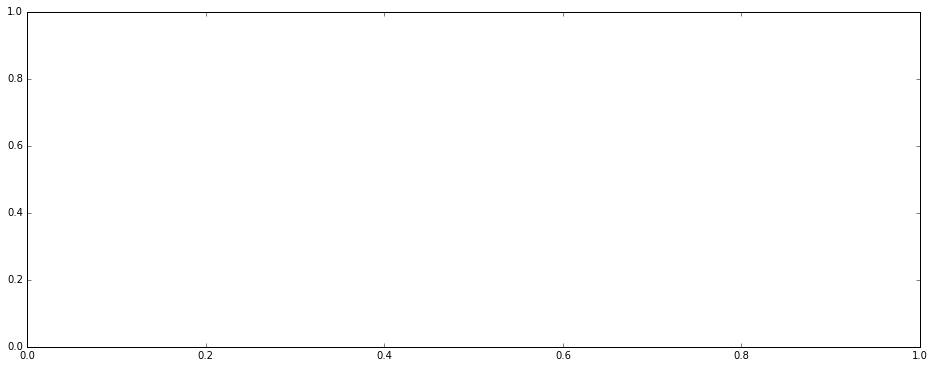

In [155]:
#plot degree of distribution
import pandas as pd
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
df = pd.read_csv('eda.out',sep='\t',header=None)
df.columns = ['links','nodes']
df.set_index('links',inplace=True)
df.plot(kind='bar',legend=None,title="Degree of Distribution",ax=ax)
plt.xlabel("Number of links")
plt.ylabel("Number of Nodes")
plt.xlim([0, 100])

### HW 7.4: Shortest path graph distances (Wikipedia)===

HW 7.4: Shortest path graph distances (Wikipedia)===

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.

In [ ]:
#currently the code doesnt do join with indices file. It just stores it in memory

In [140]:
!python run_sssp_72.py wikipedia 6176135 13466359 emr j-7FZ6QR3DYVXI

6176135 13466359 emr
No handlers could be found for logger "mrjob.conf"
Iteration: 0
Continue iteration as queued nodes left to visit
Iteration: 1
Continue iteration as queued nodes left to visit
Iteration: 2
Path found - breaking from loop
Ireland->Seamus Heaney->University of California, Berkeley


### HW 7.5: Conceptual exercise: Largest single-source network distances===

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

### Answer
Implementation for largest network distance from a single source:

    This can be implemented by doing a BFS similar to the shortest path problem. For an unweighted
    graph or a graph with equal weights, I would employ the same approach as used for shortest path above.
    The minor difference would be that the loop would not terminate when the destination is seen but rather
    when there are no more nodes that can be visited or that there are no more "queued" nodes for the next
    iteration. The latter condition ensures that we do not continue looping for nodes that are not reachable
    from the source. The no. of iterations that ran till this point ( the source node would be traversed in
    iteration 0 ) would denote the largest network distance to the furthest node. The nodes that were
    traversed/visited in the last iteration can be considered the furthest nodes from the source.
    For weighted graphs, the same approach can be employed but the condition of termination is different as we 
    would need to revisit nodes as weights via other paths may be higher. In this scenario, we would re-queue
    nodes if the new total weight of the path is higher than the previous value ( unlike the shortest path 
    solution where the node is re-queued only if the weight is less). Also, unlike unweighted graphs, we need
    to track the node and respective path for the highest seen total weight and keep it updated during each
    iteration. For weighted graphs, nodes visited in the last iteration need not be the farthest from the source.
    
    
    
    
     















### HW 7.6: Computational exercise: Largest single-source network distances (optional)===

Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.



In [148]:
# Terminate Cluster
!python -m mrjob.tools.emr.terminate_job_flow j-7FZ6QR3DYVXI

using configs in /Users/hetal/.mrjob.conf
using existing scratch bucket mrjob-f7f5fce3ffcc49a1
using s3://mrjob-f7f5fce3ffcc49a1/tmp/ as our scratch dir on S3
Terminated job flow j-7FZ6QR3DYVXI
